# Feature Engineering

Goal of this notebook is to analyze the delta between creation of shipment and first hub scan (FHS) which happens when the parcel arrives at the last mile carrier. this time includes the time of transport which is our target.

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Installing packages from requirements.txt

In [15]:
!pip install -e ../.

Obtaining file:///Users/christianklaus/code/christianklausML/dispatcher-project
  Preparing metadata (setup.py) ... done


  Attempting uninstall: dispatcher
    Found existing installation: dispatcher 1.0
    Uninstalling dispatcher-1.0:
      Successfully uninstalled dispatcher-1.0
  Running setup.py develop for dispatcher
You should consider upgrading via the '/Users/christianklaus/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [17]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import seaborn as sns
plt.style.use("dark_background")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
#from dispatcher.data.data import RawData
#from dispatcher.data.data import save_clean_shipment_data
from dispatcher.data.ticket import Ticket
from dispatcher.data.shipment import Shipment
import datetime

ModuleNotFoundError: No module named 'dispatcher'

## Loading

In [4]:
shipment = RawData.get_table_data('shipment', clean=False)
shipment.head()

/Users/christianklaus/code/N1tram/dispatcher/dispatcher/data/data.py:75: DtypeWarning: Columns (4,12,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{path}/{table}.csv')


,ID,CARRIER_ID,SHOP_ID,CUSTOMER_ADDRESS_COUNTRY_ID,CUSTOMER_ADDRESS_ZIP_CODE,CARRIER_SERVICE,RETURN_PARCEL,PICKUP_POINT_SELECTED,WEIGHT,PLANNED_PICKUP_TIMESTAMP,...,RELATION_ID,RELATION_DISTANCE,RELATION_FREQUENCY,LOGISTICAL_DETAILS,RELATION_SEVEN_SENDERS_TRANSPORT_MODE,TMS_RELATION_TYPE,ORIGIN_ZIP_CODE,ORIGIN_COUNTRY,DESTINATION_ZIP_CODE,DESTINATION_COUNTRY
0,169412848,2,405,216,8400,standard,0,0,6.2,2022-03-04 17:26:56.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH
1,169265841,2,405,216,1015,standard,0,0,26.3,2022-03-03 19:23:57.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH
2,170520112,2,405,216,6153,standard,0,0,8.4,2022-03-11 15:43:42.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH
3,169681312,2,405,216,2300,standard,0,0,11.4,2022-03-07 16:50:36.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH
4,169641352,2,405,216,6430,standard,0,0,14.7,2022-03-07 15:09:10.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH


In [5]:
shipment.keys().size

28

In [6]:
shipment = shipment[['ID', 'CARRIER_ID', 'SHOP_ID', 'CUSTOMER_ADDRESS_COUNTRY_ID',
       'CUSTOMER_ADDRESS_ZIP_CODE', 'RETURN_PARCEL', 'PLANNED_PICKUP_TIMESTAMP',
       'CREATED_AT', 'WAREHOUSE_ID',
       'ORDER_ID', 'SLA_DAYS', 'TRACKABLE', 'RELATION_ID', 'RELATION_DISTANCE',
       'ORIGIN_ZIP_CODE', 'ORIGIN_COUNTRY', 'DESTINATION_ZIP_CODE',
       'DESTINATION_COUNTRY']]

In [7]:
ticket = RawData.get_table_data('ticket', clean=False)
ticket.head()

,ID,SHIPMENT_ID,STATUS_ID,NOTES,TYPE_ID,CREATEDAT,SHIPMENT_TIMELINE_ID,STATUS,RECORD_UPDATED_AT,ORDER_ID,SHOP_ID,TIME
0,1991335581,170551890.0,NaN,NaN,38,2022-05-13 05:31:35.000,994191806.0,new,2022-05-13 05:31:35.000,NaN,196,2022-03-15 10:45:00.000
1,1991335583,170551890.0,NaN,NaN,33,2022-05-13 05:31:35.000,994191806.0,new,2022-05-13 05:31:35.000,NaN,196,2022-03-15 10:45:00.000
2,1991335585,171118033.0,NaN,NaN,38,2022-05-13 05:31:36.000,994191808.0,new,2022-05-13 05:31:36.000,NaN,196,2022-03-18 10:32:00.000
3,1991335586,171118033.0,NaN,NaN,34,2022-05-13 05:31:36.000,994191808.0,new,2022-05-13 05:31:36.000,NaN,196,2022-03-18 10:32:00.000
4,1991350152,169424918.0,NaN,NaN,5,2022-05-13 05:43:53.000,994199312.0,new,2022-05-13 05:43:53.000,NaN,196,2022-05-12 10:00:00.000


In [8]:
ticket.keys()

Index(['ID', 'SHIPMENT_ID', 'STATUS_ID', 'NOTES', 'TYPE_ID', 'CREATEDAT',
       'SHIPMENT_TIMELINE_ID', 'STATUS', 'RECORD_UPDATED_AT', 'ORDER_ID',
       'SHOP_ID', 'TIME'],
      dtype='object')

In [9]:
ticket = ticket[['ID', 'SHIPMENT_ID', 'TYPE_ID',
       'ORDER_ID',
       'TIME']]

In [10]:
ticket_type = RawData.get_table_data('ticket_type', clean=False)
ticket_type.head()

,ID,NAME,DESCRIPTION,CREATEDAT,EVENT_NAME,LEVEL,MEANING,LIMIT_OCCURRENCES,PARENT_ID,SEQUENCE_NUMBER,IS_CUSTOM,RECORD_UPDATED_AT,TRACKABLE,ACTIVE
0,1,Carded,Customer received a notification card inside h...,NaN,NaN,shipment,good,1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1
1,2,Wrong address,Consignee address not correct. Please contact ...,NaN,NaN,shipment,really_bad,-1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1
2,3,Light damage,Shipment was damaged but is still on the way t...,NaN,NaN,shipment,bad,-1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1
3,4,Notify recipient,Send Mail to recipient: Undeliverable,NaN,NaN,shipment,bad,-1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1
4,5,Contact carrier,Get in touch with the Last Mile Carrier (LMC) ...,NaN,NaN,shipment,bad,-1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1


In [11]:
ticket_type = ticket_type[['ID', 'NAME']]

## Merging and feature creation

In [12]:
ticket = ticket.merge(ticket_type, how='left', left_on='TYPE_ID', right_on='ID')

In [13]:
shipment_ticket = shipment.merge(ticket, how='left', left_on='ID', right_on='SHIPMENT_ID')

In [14]:
shipment_ticket.isnull().sum()

ID                                    0
CARRIER_ID                            0
SHOP_ID                               0
CUSTOMER_ADDRESS_COUNTRY_ID           0
CUSTOMER_ADDRESS_ZIP_CODE            63
RETURN_PARCEL                         0
PLANNED_PICKUP_TIMESTAMP              0
CREATED_AT                            0
WAREHOUSE_ID                          0
ORDER_ID_x                            0
SLA_DAYS                        9759744
TRACKABLE                             0
RELATION_ID                           0
RELATION_DISTANCE               1093001
ORIGIN_ZIP_CODE                  949387
ORIGIN_COUNTRY                   949387
DESTINATION_ZIP_CODE            1093001
DESTINATION_COUNTRY             1093001
ID_x                               1557
SHIPMENT_ID                        1557
TYPE_ID                            1557
ORDER_ID_y                     15483214
TIME                               1557
ID_y                               1557
NAME                               1557


In [15]:
ticket['FHS'] = ticket.loc[ticket["TYPE_ID"] == 17]['TIME']

In [16]:
tmp = ticket[['SHIPMENT_ID', 'FHS']]

In [17]:
ticket = ticket.drop(columns="FHS")

In [18]:
tmp = tmp.dropna(subset=['FHS'])

In [19]:
ticket['SHIPMENT_CREATED'] = ticket.loc[ticket["NAME"] == 'Shipment created']['TIME']

In [20]:
tmp2 = ticket[['SHIPMENT_ID', 'SHIPMENT_CREATED']]

In [21]:
ticket = ticket.drop(columns="SHIPMENT_CREATED")

In [22]:
tmp2 = tmp2.dropna(subset=['SHIPMENT_CREATED'])

In [23]:
shipment_ticket = shipment.merge(ticket, how='left', left_on='ID', right_on='SHIPMENT_ID')

In [24]:
shipment_ticket = shipment_ticket.merge(tmp, how='left', left_on='ID', right_on='SHIPMENT_ID')

In [25]:
shipment_ticket = shipment_ticket.merge(tmp2, how='left', left_on='ID', right_on='SHIPMENT_ID')

In [26]:
shipment_ticket['FHS'] = pd.to_datetime(shipment_ticket['FHS'])

In [27]:
shipment_ticket['SHIPMENT_CREATED'] = pd.to_datetime(shipment_ticket['SHIPMENT_CREATED'])

In [1]:
shipment['CREATED_AT'] = pd.to_datetime(shipment['CREATED_AT'])

NameError: name 'pd' is not defined

In [28]:
shipment_ticket['PLANNED_PICKUP_TIMESTAMP'] = pd.to_datetime(shipment_ticket['PLANNED_PICKUP_TIMESTAMP'])

In [29]:
shipment_ticket['FHS_MINUS_SHIPMENT_CREATED'] = shipment_ticket['FHS'] - shipment_ticket['SHIPMENT_CREATED']

In [30]:
shipment_ticket[['ID','FHS', 'SHIPMENT_CREATED', 'FHS_MINUS_SHIPMENT_CREATED']]

,ID,FHS,SHIPMENT_CREATED,FHS_MINUS_SHIPMENT_CREATED
0,169412848,2022-03-10 16:25:01,2022-03-04 16:26:58,5 days 23:58:03
1,169412848,2022-03-10 16:25:01,2022-03-04 16:26:58,5 days 23:58:03
2,169412848,2022-03-10 16:25:01,2022-03-04 16:26:58,5 days 23:58:03
3,169412848,2022-03-10 16:25:01,2022-03-04 16:26:58,5 days 23:58:03
4,169412848,2022-03-10 16:25:01,2022-03-04 16:26:58,5 days 23:58:03
...,...,...,...,...
15704993,173607170,2022-04-05 12:58:00,2022-03-31 00:12:12,5 days 12:45:48
15704994,173607170,2022-04-05 12:58:00,2022-03-31 00:12:12,5 days 12:45:48
15704995,173607170,2022-04-05 12:58:00,2022-03-31 00:12:12,5 days 12:45:48
15704996,173607170,2022-04-05 12:58:00,2022-03-31 00:12:12,5 days 12:45:48


In [31]:
shipment_times = shipment_ticket.drop_duplicates(subset=['ID'])[['ID','FHS', 'SHIPMENT_CREATED', 'FHS_MINUS_SHIPMENT_CREATED']]

*play with time horizon: change days parameter*

In [32]:
shipment_times_filtered = shipment_times[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] <= datetime.timedelta(days=2)]

In [33]:
shipment_times_filtered = shipment_times_filtered[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] >= datetime.timedelta(days=0)]

/var/folders/_7/bhnzdc191yv6brswc0vzw5sr0000gn/T/ipykernel_82627/1584034457.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shipment_times_filtered = shipment_times_filtered[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] >= datetime.timedelta(days=0)]


In [34]:
shipment_times_filtered

,ID,FHS,SHIPMENT_CREATED,FHS_MINUS_SHIPMENT_CREATED
40,172120851,2022-03-23 16:10:20,2022-03-22 11:22:58,1 days 04:47:22
192,168962697,2022-03-03 19:15:48,2022-03-02 07:59:08,1 days 11:16:40
231,172430335,2022-03-25 19:54:40,2022-03-23 20:18:59,1 days 23:35:41
301,170981329,2022-03-16 17:07:59,2022-03-15 08:56:44,1 days 08:11:15
357,171966910,2022-03-23 16:27:33,2022-03-21 18:05:06,1 days 22:22:27
...,...,...,...,...
15699594,168705474,2022-03-02 17:31:00,2022-03-01 01:54:19,1 days 15:36:41
15701031,168705227,2022-03-02 17:43:00,2022-03-01 01:44:45,1 days 15:58:15
15702504,168705421,2022-03-02 23:20:00,2022-03-01 01:51:44,1 days 21:28:16
15703289,168705446,2022-03-02 17:49:00,2022-03-01 01:53:11,1 days 15:55:49


<AxesSubplot:ylabel='Frequency'>

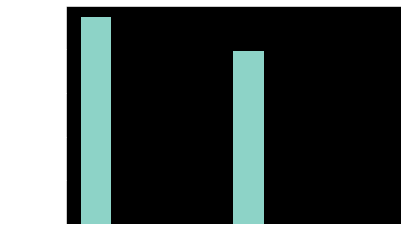

In [35]:
shipment_times_filtered['FHS_MINUS_SHIPMENT_CREATED'].astype('timedelta64[D]').plot.hist()

<AxesSubplot:xlabel='FHS_MINUS_SHIPMENT_CREATED', ylabel='Count'>

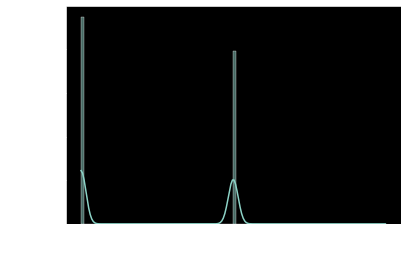

In [36]:
sns.histplot(shipment_times_filtered['FHS_MINUS_SHIPMENT_CREATED'].astype('timedelta64[D]'), kde=True)

<AxesSubplot:xlabel='FHS_MINUS_SHIPMENT_CREATED', ylabel='Count'>

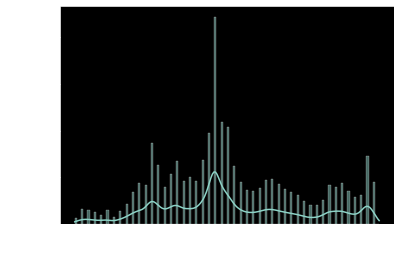

In [37]:
sns.histplot(shipment_times_filtered['FHS_MINUS_SHIPMENT_CREATED'].astype('timedelta64[h]'), kde=True)

* timeframes less than 24h are same day delivery. 
* longer than a week are definitely outliers.

## Data Analysis

In [38]:
corr = shipment_ticket.corr()

In [39]:
shipment_ticket[(shipment_ticket['RETURN_PARCEL'] == 0)]

,ID,CARRIER_ID,SHOP_ID,CUSTOMER_ADDRESS_COUNTRY_ID,CUSTOMER_ADDRESS_ZIP_CODE,RETURN_PARCEL,PLANNED_PICKUP_TIMESTAMP,CREATED_AT,WAREHOUSE_ID,ORDER_ID_x,...,TYPE_ID,ORDER_ID_y,TIME,ID_y,NAME,SHIPMENT_ID_y,FHS,SHIPMENT_ID,SHIPMENT_CREATED,FHS_MINUS_SHIPMENT_CREATED
0,169412848,2,405,216,8400,0,2022-03-04 17:26:56,2022-03-04 16:26:58.000,604,151004966,...,17.0,NaN,2022-03-10 16:25:01.000,17.0,First hub scan,169412848.0,2022-03-10 16:25:01,169412848.0,2022-03-04 16:26:58,5 days 23:58:03
1,169412848,2,405,216,8400,0,2022-03-04 17:26:56,2022-03-04 16:26:58.000,604,151004966,...,40.0,NaN,2022-03-11 07:42:31.000,40.0,Out for delivery,169412848.0,2022-03-10 16:25:01,169412848.0,2022-03-04 16:26:58,5 days 23:58:03
2,169412848,2,405,216,8400,0,2022-03-04 17:26:56,2022-03-04 16:26:58.000,604,151004966,...,55.0,NaN,2022-03-07 08:01:05.000,55.0,Delivery requested at the carrier's,169412848.0,2022-03-10 16:25:01,169412848.0,2022-03-04 16:26:58,5 days 23:58:03
3,169412848,2,405,216,8400,0,2022-03-04 17:26:56,2022-03-04 16:26:58.000,604,151004966,...,43.0,NaN,2022-03-11 06:20:03.000,43.0,Hub scan,169412848.0,2022-03-10 16:25:01,169412848.0,2022-03-04 16:26:58,5 days 23:58:03
4,169412848,2,405,216,8400,0,2022-03-04 17:26:56,2022-03-04 16:26:58.000,604,151004966,...,38.0,NaN,2022-03-11 12:36:43.000,38.0,Delivered,169412848.0,2022-03-10 16:25:01,169412848.0,2022-03-04 16:26:58,5 days 23:58:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15704993,173607170,93,784,235,GU34 5PB,0,2022-03-31 17:00:00,2022-03-31 00:12:12.000,1329,154748098,...,43.0,NaN,2022-04-06 00:33:00.000,43.0,Hub scan,173607170.0,2022-04-05 12:58:00,173607170.0,2022-03-31 00:12:12,5 days 12:45:48
15704994,173607170,93,784,235,GU34 5PB,0,2022-03-31 17:00:00,2022-03-31 00:12:12.000,1329,154748098,...,39.0,NaN,2022-03-31 17:00:00.000,39.0,Warehouse pick-up,173607170.0,2022-04-05 12:58:00,173607170.0,2022-03-31 00:12:12,5 days 12:45:48
15704995,173607170,93,784,235,GU34 5PB,0,2022-03-31 17:00:00,2022-03-31 00:12:12.000,1329,154748098,...,55.0,NaN,2022-03-31 22:00:00.000,55.0,Delivery requested at the carrier's,173607170.0,2022-04-05 12:58:00,173607170.0,2022-03-31 00:12:12,5 days 12:45:48
15704996,173607170,93,784,235,GU34 5PB,0,2022-03-31 17:00:00,2022-03-31 00:12:12.000,1329,154748098,...,47.0,NaN,2022-03-31 00:12:12.000,47.0,Shipment created,173607170.0,2022-04-05 12:58:00,173607170.0,2022-03-31 00:12:12,5 days 12:45:48


In [40]:
shipment_ticket = shipment_ticket.dropna(subset=['SHIPMENT_CREATED', 'FHS'])

In [41]:
shipment_ticket['PICKUP_DOW'] = shipment_ticket['PLANNED_PICKUP_TIMESTAMP'].dt.day_of_week

In [49]:
shipment_ticket['PICKUP_HR'] = shipment_ticket['PLANNED_PICKUP_TIMESTAMP'].dt.hour

AttributeError: 'DataFrame' object has no attribute 'dt'

In [42]:
shipment_ticket['CREATED_DOW'] = shipment_ticket['SHIPMENT_CREATED'].dt.day_of_week

In [ ]:
shipment_ticket['CREATED_HR'] = shipment_ticket['SHIPMENT_CREATED'].dt.hour

In [43]:
shipment_ticket['CREATED_MON_TUE_WED_THU'] = np.where(shipment_ticket.CREATED_DOW <= 3, 1, 0)

In [ ]:
shipment_ticket['CREATED_BEFORE_3PM'] = np.where(shipment_ticket.CREATED_HR <= 16, 1, 0)

In [44]:
shipment_ticket = shipment_ticket.astype({'CREATED_MON_TUE_WED_THU': 'int8',
                       'CREATED_DOW': 'int8',
                       'PICKUP_DOW': 'int8'
                       })

In [45]:
dum = pd.get_dummies(shipment_ticket, columns=['CREATED_DOW'])
shipment_ticket = pd.concat([shipment_ticket, dum], axis=1)
shipment_ticket.sample(5)

,ID,CARRIER_ID,SHOP_ID,CUSTOMER_ADDRESS_COUNTRY_ID,CUSTOMER_ADDRESS_ZIP_CODE,RETURN_PARCEL,PLANNED_PICKUP_TIMESTAMP,CREATED_AT,WAREHOUSE_ID,ORDER_ID_x,...,FHS_MINUS_SHIPMENT_CREATED,PICKUP_DOW,CREATED_MON_TUE_WED_THU,CREATED_DOW_0,CREATED_DOW_1,CREATED_DOW_2,CREATED_DOW_3,CREATED_DOW_4,CREATED_DOW_5,CREATED_DOW_6
15670125,172770042,87,71,110,29010,0,2022-03-25 14:00:00,2022-03-25 16:46:58.000,649,153877042,...,0 days 00:13:02,4,0,0,0,0,0,1,0,0
1028487,170976813,9,774,76,75012,0,2022-03-15 08:34:14,2022-03-15 08:34:14.000,1348,152445021,...,2 days 09:05:01,1,1,0,1,0,0,0,0,0
15410310,169369180,1,324,216,3772,0,2022-03-04 12:04:14,2022-03-04 12:00:41.000,452,150971897,...,3 days 19:16:49,4,0,0,0,0,0,1,0,0
4405968,169285678,5,196,15,4550,0,2022-03-03 20:13:56,2022-03-03 20:33:30.000,310,150898034,...,3 days 16:23:10,3,1,0,0,0,1,0,0,0
5184455,171327708,87,196,110,35011,0,2022-03-16 19:16:14,2022-03-16 19:38:53.000,613,152745930,...,0 days 21:21:07,2,1,0,0,1,0,0,0,0


In [48]:
dum = pd.get_dummies(shipment_ticket, columns=['PICKUP_DOW'])
shipment_ticket = pd.concat([shipment_ticket, dum], axis=1)
shipment_ticket.sample(5)

,ID,CARRIER_ID,SHOP_ID,CUSTOMER_ADDRESS_COUNTRY_ID,CUSTOMER_ADDRESS_ZIP_CODE,RETURN_PARCEL,PLANNED_PICKUP_TIMESTAMP,CREATED_AT,WAREHOUSE_ID,ORDER_ID_x,...,PICKUP_DOW_4,PICKUP_DOW_5,PICKUP_DOW_6,PICKUP_DOW_0,PICKUP_DOW_1,PICKUP_DOW_2,PICKUP_DOW_3,PICKUP_DOW_4,PICKUP_DOW_5,PICKUP_DOW_6
11833157,171696694,13,71,76,68000,0,2022-03-18 14:00:00,2022-03-19 02:18:08.000,649,152971626,...,1,0,0,0,0,0,0,1,0,0
10924265,169780721,55,465,61,9330,0,2022-03-07 21:50:00,2022-03-07 23:59:52.000,673,151426351,...,0,0,0,1,0,0,0,0,0,0
13252867,173062838,6,196,15,2521,0,2022-03-28 14:03:53,2022-03-28 15:13:11.000,310,154322298,...,0,0,0,1,0,0,0,0,0,0
4144464,171934646,5,196,15,2540,0,2022-03-21 15:03:33,2022-03-21 15:56:46.000,310,153336564,...,0,0,0,1,0,0,0,0,0,0
11084328,171693161,55,465,215,73740,0,2022-03-18 21:50:00,2022-03-18 23:53:20.000,673,153058123,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
shipment_ticket.dtypes

In [ ]:
shipment_ticket.sample(5)

In [ ]:
fig, ax = plt.subplots(figsize=(13,13)) 
sns.heatmap(corr, annot=True, ax=ax)